In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
file_path = "/content/drive/My Drive/Semester2/DeepLearning/Tugas 1/Dataset.xlsx"
dataset1 = pd.read_excel(file_path, sheet_name="Data", header=None)
dataset1.columns = ["X1", "X2", "X3", "X4", "Target"]
dataset1.insert(0, "X0", 1)


In [18]:
# inisialisasi kolom
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE",
            "dbias","dteta1","dteta2","dteta3","dteta4"]:
    dataset1[col] = 0.0

In [19]:
# Preprocessing: Encoding kolom 'object' jika ada
for column in dataset1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset1[column] = le.fit_transform(dataset1[column])

In [20]:
X = dataset1[["X0", "X1", "X2", "X3", "X4"]]
y = dataset1["Target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle= False)

In [22]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df   = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

In [23]:
# inisialisasi kolom tambahan untuk training data
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE",
            "dbias","dteta1","dteta2","dteta3","dteta4"]:
    train_df[col] = 0.0
# Inisialisasi kolom tambahan untuk validation data
for col in ["bias","teta1","teta2","teta3","teta4","dotz","sigmoid","prediksi","error","SSE"]:
    val_df[col] = 0.0

In [24]:
# --- MULAI PROSES TRAINING ---

learning_rate = 0.1
epochs = 5
# Inisialisasi nilai awal
initial_bias  = 0.5
initial_teta1 = 0.5
initial_teta2 = 0.5
initial_teta3 = 0.5
initial_teta4 = 0.5

# Simpan bobot awal ke baris 0 training_df
train_df.loc[:, ["bias","teta1","teta2","teta3","teta4"]] = 0.0
train_df.loc[:, ["dbias","dteta1","dteta2","dteta3","dteta4"]] = 0.0

# Variabel untuk menyimpan history loss
training_loss_history = []
validation_loss_history = []
training_accuracy_history = []
validation_accuracy_history = []

# --- TRAINING LOOP ---
for epoch in range(epochs):
    # bobot awal untuk epoch
    bias  = initial_bias if epoch == 0 else bias
    teta1 = initial_teta1 if epoch == 0 else teta1
    teta2 = initial_teta2 if epoch == 0 else teta2
    teta3 = initial_teta3 if epoch == 0 else teta3
    teta4 = initial_teta4 if epoch == 0 else teta4

    for i in range(len(train_df)):
        # Ambil data
        x0 = train_df.loc[i, "X0"]
        x1 = train_df.loc[i, "X1"]
        x2 = train_df.loc[i, "X2"]
        x3 = train_df.loc[i, "X3"]
        x4 = train_df.loc[i, "X4"]
        target = train_df.loc[i, "Target"]

        # Forward pass
        dotz = (x0*bias + x1*teta1 + x2*teta2 + x3*teta3 + x4*teta4)
        sigmoid = 1 / (1 + np.exp(-dotz))
        pred = 1 if sigmoid > 0.5 else 0
        error = sigmoid - target
        sse = error**2

        # Gradien (sesuai Excel: ada faktor 2)
        dbias  = 2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x0
        dteta1 = 2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x1
        dteta2 = 2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x2
        dteta3 = 2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x3
        dteta4 = 2 * (sigmoid - target) * sigmoid * (1 - sigmoid) * x4

        # Simpan ke dataframe (supaya tabel sama seperti Excel)
        train_df.loc[i, "bias"]  = bias
        train_df.loc[i, "teta1"] = teta1
        train_df.loc[i, "teta2"] = teta2
        train_df.loc[i, "teta3"] = teta3
        train_df.loc[i, "teta4"] = teta4
        train_df.loc[i, "dotz"] = dotz
        train_df.loc[i, "sigmoid"] = sigmoid
        train_df.loc[i, "prediksi"] = pred
        train_df.loc[i, "error"] = error
        train_df.loc[i, "SSE"] = sse
        train_df.loc[i, "dbias"] = dbias
        train_df.loc[i, "dteta1"] = dteta1
        train_df.loc[i, "dteta2"] = dteta2
        train_df.loc[i, "dteta3"] = dteta3
        train_df.loc[i, "dteta4"] = dteta4

        # Update bobot langsung (SGD seperti Excel)
        bias  = bias  - learning_rate * dbias
        teta1 = teta1 - learning_rate * dteta1
        teta2 = teta2 - learning_rate * dteta2
        teta3 = teta3 - learning_rate * dteta3
        teta4 = teta4 - learning_rate * dteta4

    # --- Validation setelah 1 epoch selesai ---
    val_df["bias"]  = bias
    val_df["teta1"] = teta1
    val_df["teta2"] = teta2
    val_df["teta3"] = teta3
    val_df["teta4"] = teta4
    val_df["dotz"] = (val_df["X0"]*bias + val_df["X1"]*teta1 +
                      val_df["X2"]*teta2 + val_df["X3"]*teta3 +
                      val_df["X4"]*teta4)
    val_df["sigmoid"] = 1 / (1 + np.exp(-val_df["dotz"]))
    val_df["prediksi"] = val_df["sigmoid"].apply(lambda x: 1 if x > 0.5 else 0)
    val_df["error"] = val_df["sigmoid"] - val_df["Target"]
    val_df["SSE"] = val_df["error"]**2

    # Simpan history loss & akurasi
    training_loss_history.append(train_df["SSE"].mean())
    validation_loss_history.append(val_df["SSE"].mean())
    training_accuracy_history.append((train_df["prediksi"] == train_df["Target"]).mean())
    validation_accuracy_history.append((val_df["prediksi"] == val_df["Target"]).mean())

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {training_loss_history[-1]:.6f} | "
          f"Val Loss: {validation_loss_history[-1]:.6f} | "
          f"Train Acc: {training_accuracy_history[-1]:.4f} | Val Acc: {validation_accuracy_history[-1]:.4f}")


Epoch 1/5 | Train Loss: 0.449314 | Val Loss: 0.326215 | Train Acc: 0.5250 | Val Acc: 0.5000
Epoch 2/5 | Train Loss: 0.034979 | Val Loss: 0.244152 | Train Acc: 0.9500 | Val Acc: 0.5000
Epoch 3/5 | Train Loss: 0.023202 | Val Loss: 0.172498 | Train Acc: 0.9750 | Val Acc: 0.5000
Epoch 4/5 | Train Loss: 0.016483 | Val Loss: 0.116599 | Train Acc: 0.9750 | Val Acc: 0.8500
Epoch 5/5 | Train Loss: 0.012349 | Val Loss: 0.078042 | Train Acc: 0.9875 | Val Acc: 1.0000


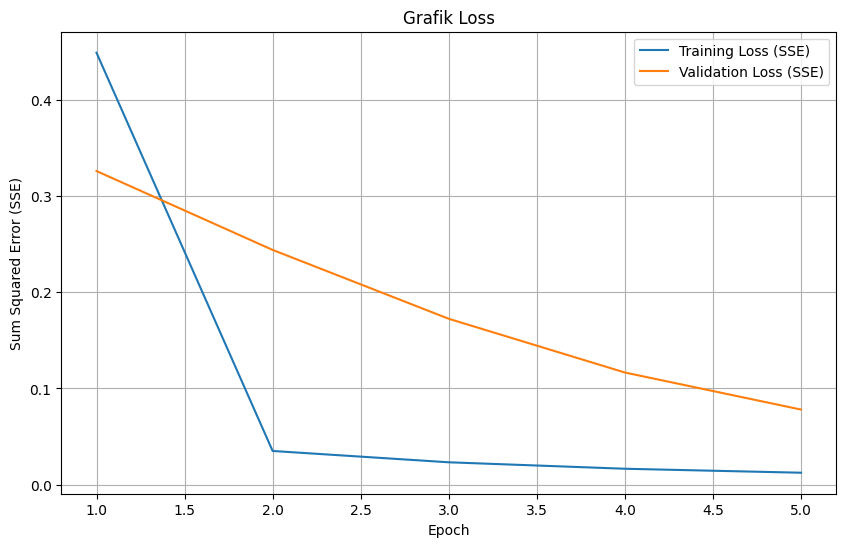

In [25]:
# --- PLOTTING FUNGSI LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_loss_history, label='Training Loss (SSE)')
plt.plot(range(1, epochs + 1), validation_loss_history, label='Validation Loss (SSE)')
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Sum Squared Error (SSE)')
plt.legend()
plt.grid(True)
plt.show()

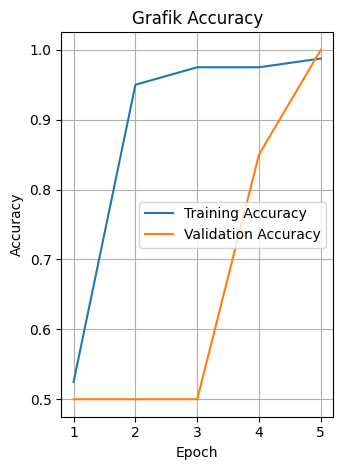

In [26]:
# --- PLOTTING FUNGSI AKURASI ---
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), training_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_history, label='Validation Accuracy')
plt.title('Grafik Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()